In [2]:
from gurobipy import Model, GRB, quicksum
import pandas as pd

model = Model("Decentralized Recycling Center Optimization")

model.setParam('Threads', 64)  # 0 tells Gurobi to use all available threads
model.setParam('MIPGap', 0.01) 
model.setParam('Method', 2)    # Barrier method (works better with parallel processing)
model.setParam('Presolve', 2)  # Aggressive presolve
model.setParam('MIPFocus', 1)  # Focus on finding feasible solutions quickly

# Dataframe
df_supply = pd.read_csv('source/cc_supply_v3_New.csv', encoding='latin-1')
df_dij = pd.read_csv('source/jarak_dealer_potensial.csv', encoding='latin-1', dtype={'Jarak': float})
df_djk = pd.read_csv('source/jarak_potensial_mrc.csv', encoding='latin-1', dtype={'Jarak': float})

# # Indeks
I = df_supply['Nama Dealer/Suplai'].unique()
T = df_supply['Period'].unique()    
J = df_dij['Potensial Lokasi'].unique()
K = df_djk['MRC'].unique()

# Parameter
sales       = 9188832           # profit 
b           = 0.18              # BEP kapasitas unit daur ulang
a           = 0.39              # faktor konversi baterai bekas menjadi black mass
i           = 879945            # biaya investasi per fasilitas
TBB         = 0.10              # biaya transportasi per kg per ton baterai bekas
TBM         = 0.05              # biaya transportasi per kg per ton black mass
CDRC        = 3960              # kapasitas unit daur ulang
fixed_cost  = 114394            # biaya tetap per tahun
var_cost    = 6236304           # biaya variabel
semvar_cost = 1033410           # biaya semi variabel 

# Unit
sales_per_unit = sales / CDRC                    # profit per unit
var_cost_per_unit = var_cost / CDRC              # variable cost per unit
semvar_cost_per_unit = semvar_cost / CDRC        # semi variable cost per unit

# Data Supply
supply = {(row['Nama Dealer/Suplai'], row['Period']): row['Supply'] 
          for _, row in df_supply.iterrows()}

# Data Matriks Jarak
dij = {
    (row['Nama Dealer'], row['Potensial Lokasi']): float(row['Jarak'])
    for _, row in df_dij.iterrows()
}

djk = {
    (row['Nama Potensial Lokasi'], row['MRC']): float(row['Jarak'])
    for _, row in df_djk.iterrows()
}

# Decision Variables
ojt = model.addVars(J, T, vtype=GRB.BINARY, name="ojt")
xijt = model.addVars(I, J, T, vtype=GRB.CONTINUOUS, lb=0, name="xijt")
yjkt = model.addVars(J, K, T, vtype=GRB.CONTINUOUS, lb=0, name="yjkt")

# Handle Variables
vjt = model.addVars(J, T, vtype=GRB.BINARY, name="vjt")
zkt = model.addVars(K, T, vtype=GRB.BINARY, name="zkt")
sit = model.addVars(I, T, vtype=GRB.CONTINUOUS, name="sit")

# Objective Function Components
revenue_jt = {}
investment_jt = {}
fixed_cost_jt = {}
variable_cost_jt = {}
semivariable_cost_jt = {}
transport_cost_bb_jt = {}  # Transport cost for used batteries
transport_cost_bm_jt = {}  # Transport cost for black mass
profit_jt = {}

for j in J:
    for t in T:
        # Revenue for facility j in year t
        revenue_jt[j,t] = quicksum(sales_per_unit * xijt[i,j,t] for i in I)
        
        # Investment cost for facility j in year t
        investment_jt[j,t] = i * ojt[j,t]
        
        # Fixed cost for facility j in year t
        fixed_cost_jt[j,t] = fixed_cost * vjt[j,t]
        
        # Variable cost for facility j in year t
        variable_cost_jt[j,t] = quicksum(var_cost_per_unit * xijt[i,j,t] for i in I)
        
        # Semi variable cost for facility j in year t
        semivariable_cost_jt[j,t] = quicksum(semvar_cost_per_unit * xijt[i,j,t] for i in I)
        
        # Transportation costs split into BB and BM
        transport_cost_bb_jt[j,t] = quicksum(TBB * dij[i,j] * xijt[i,j,t] for i in I)
        transport_cost_bm_jt[j,t] = quicksum(TBM * djk[j,k] * yjkt[j,k,t] for k in K)
        
        # Profit after tax for facility j in year t
        profit_jt[j,t] = (revenue_jt[j,t] - (fixed_cost_jt[j,t] + variable_cost_jt[j,t] + 
                         semivariable_cost_jt[j,t] + transport_cost_bb_jt[j,t] + 
                         transport_cost_bm_jt[j,t])) * (1-22/100)

# Total profit after tax minus investment costs
total_profit = quicksum(profit_jt[j,t] for j in J for t in T) - \
               quicksum(investment_jt[j,t] for j in J for t in T)

# Set Objective
model.setObjective(total_profit, GRB.MAXIMIZE)

# Constraints
# DRC Sustainability
first_period = min(T)
for j in J:
    # t = first_period
    model.addConstr(vjt[j,first_period] == ojt[j,first_period])
    
    # t > first_period
    for t in [t for t in T if t > first_period]:
        model.addConstr(vjt[j,t] == ojt[j,t] + vjt[j,t-1])

# Handling Auxiliary Variable vjt
for j in J:
    for t in T:
        model.addConstr(vjt[j,t] <= 1)

# Dynamic Supply
for i in I:
    # Initial supply at first period
    model.addConstr(sit[i,first_period] == supply[i,first_period])
    
    # Supply balance for subsequent periods
    for t in [t for t in T if t < max(T)]:  # atau bisa juga list(T)[:-1]
        model.addConstr(
            sit[i,t+1] == sit[i,t] - quicksum(xijt[i,j,t] for j in J) + supply[i,t+1]
        )

# Flow Constraint
for i in I:
    for t in T:
        model.addConstr(
            quicksum(xijt[i,j,t] for j in J) <= sit[i,t]
        )

# Mass Balance
for j in J:
    for k in K:
        for t in T:
            model.addConstr(
                yjkt[j,k,t] == a * quicksum(xijt[i,j,t] for i in I)
            )

# Capacity Constraints
for j in J:
    for t in T:
        model.addConstr(b * CDRC * vjt[j,t] <= quicksum(xijt[i,j,t] for i in I))
        model.addConstr(quicksum(xijt[i,j,t] for i in I) <= CDRC * vjt[j,t])

# Allocation Handling
M = max(max(supply.values()), CDRC)
for i in I:
    for j in J:
        for t in T:
            model.addConstr(xijt[i,j,t] <= M * vjt[j,t])

# Handle zkt Variable
for j in J:
    for k in K:
        for t in T:
            model.addConstr(yjkt[j,k,t] <= M * zkt[k,t])

# Optimize
model.optimize()

Set parameter Threads to value 64
Set parameter MIPGap to value 0.01
Set parameter Method to value 2
Set parameter Presolve to value 2
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen Threadripper 7970X 32-Cores, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 32 physical cores, 64 logical processors, using up to 64 threads

Non-default parameters:
MIPGap  0.01
Method  2
MIPFocus  1
Presolve  2
Threads  64

Optimize a model with 1521228 rows, 1502222 columns and 10351200 nonzeros
Model fingerprint: 0x8c19373e
Variable types: 1498431 continuous, 3791 integer (3791 binary)
Coefficient statistics:
  Matrix range     [4e-01, 4e+03]
  Objective range  [2e-02, 9e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 2e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 541456 rows and 532555 columns (presolve time = 5s)...
Presolve removed 541567 rows and 532555 columns (

#### Print Flow Material

In [3]:
# Create and save flow material table to Excel
import pandas as pd
import os

# Create directory if it doesn't exist
save_dir = "Skenario Indonesia"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Prepare data for DataFrame
data = []
for j in J:
    for t in T:
        if vjt[j,t].x > 0.5:
            # Get suppliers and their flow values
            suppliers = []
            inflow_values = []
            total_inflow = 0.0
            for i in I:
                if xijt[i,j,t].x > 0.001:
                    suppliers.append(f"{i}")
                    inflow_values.append(f"{xijt[i,j,t].x:.2f}")
                    total_inflow += xijt[i,j,t].x
            
            # Get total outflow to MRC
            outflow = sum(yjkt[j,k,t].x for k in K)
            
            # Format the strings
            suppliers_str = ", ".join(suppliers)
            inflow_values_str = ", ".join(inflow_values)
            
            data.append({
                'DRC': j,
                'Year': t,
                'Suppliers': suppliers_str,
                'Inflow Values': inflow_values_str,
                'Total Inflow': f"{total_inflow:.2f}",
                'Outflow to MRC': f"{outflow:.2f}"
            })

# Create DataFrame and save to Excel
df = pd.DataFrame(data)
excel_path = os.path.join(save_dir, 'flow_material_S1_3.xlsx')
df.to_excel(excel_path, index=False)

#### Print Cost

In [4]:
# Create and save cost breakdown table to Excel
import os
import pandas as pd

# Create directory if it doesn't exist
save_dir = "Skenario Indonesia"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Prepare data for DataFrame
data = []
total_profit = model.ObjVal  # Calculate total profit once
total_investment_value = sum(investment_jt[j, t].getValue() for j in J for t in T)  # Calculate total investment

for j in J:
    for t in T:
        if vjt[j, t].x > 0.5:
            data.append({
                'j': j,
                't': t,
                'Transport BB': transport_cost_bb_jt[j, t].getValue(),
                'Fixed Cost': fixed_cost_jt[j, t].getValue(),
                'Var Cost': variable_cost_jt[j, t].getValue(),
                'Semi Var Cost': semivariable_cost_jt[j, t].getValue(),
                'Transport BM': transport_cost_bm_jt[j, t].getValue(),
                'Sales': revenue_jt[j, t].getValue(),
                'Profit After Tax': profit_jt[j, t].getValue(),
                'Total Investment': investment_jt[j,t].getValue() if ojt[j,t].x > 0.5 else 0,
                'Total Objective Value': ''  # Add new empty column
            })

# Create DataFrame
df = pd.DataFrame(data)

# Add the total values to the first row of the respective columns
df.loc[0, 'Total Objective Value'] = total_profit

# Save to Excel
excel_path = os.path.join(save_dir, 'cost_breakdown_S1_v3.xlsx')
df.to_excel(excel_path, index=False)

# Calculate total costs
total_transport_bb = sum(transport_cost_bb_jt[j, t].getValue() for j in J for t in T)
total_transport_bm = sum(transport_cost_bm_jt[j, t].getValue() for j in J for t in T)
total_fixed = sum(fixed_cost_jt[j, t].getValue() for j in J for t in T)
total_variable = sum(variable_cost_jt[j, t].getValue() for j in J for t in T)
total_semivariable = sum(semivariable_cost_jt[j, t].getValue() for j in J for t in T)
total_revenue = sum(revenue_jt[j, t].getValue() for j in J for t in T)
total_investment = sum(investment_jt[j, t].getValue() for j in J for t in T)

#### Print Sisa Baterai Bekas

<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:6: SyntaxWarning: invalid escape sequence '\k'
C:\Users\THREADRIPPER 7970X\AppData\Local\Temp\ipykernel_7888\2876868178.py:6: SyntaxWarning: invalid escape sequence '\k'
  cc_coords = pd.read_csv('source\koordinat_dealer_combined.csv')



Results saved to Skenario Indonesia\sisa_baterai_bekas_S1_v3.xlsx


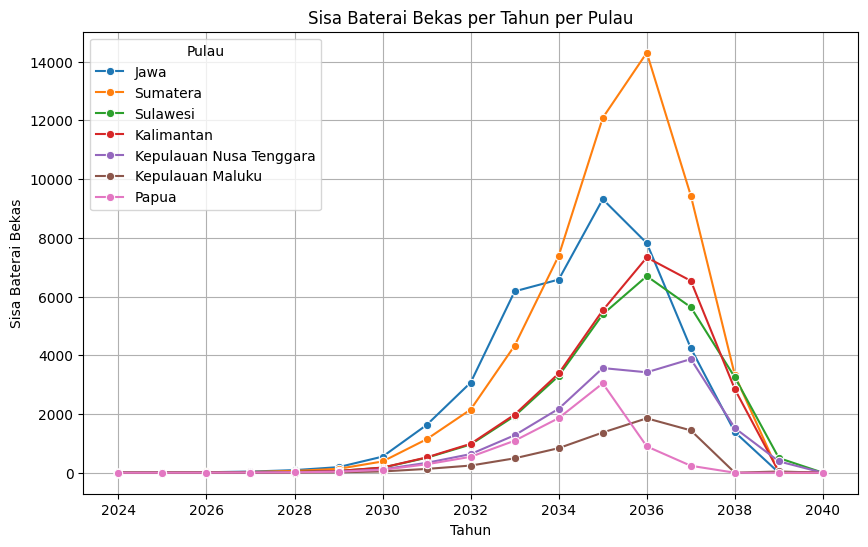

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CC coordinates with province and island data
cc_coords = pd.read_csv('source\koordinat_dealer_combined.csv')

# Create dictionary mapping CC to island
cc_to_island = {row['Nama Dealer']: row['Pulau'] for _, row in cc_coords.iterrows()}

# Create dictionary to store island totals for each year
island_totals_per_year = {year: {} for year in T}

# Calculate remaining batteries per CC and sum by island for each year
for year in T:
    for i in I:
        remaining = sit[i, year].x - sum(xijt[i, j, year].x for j in J)
        # Assume remaining is 0 if it's very small
        if abs(remaining) < 1e-5:
            remaining = 0
        island = cc_to_island[f"{i}"]
        
        if island not in island_totals_per_year[year]:
            island_totals_per_year[year][island] = 0
        island_totals_per_year[year][island] += remaining

# Convert dictionary to DataFrame
results_df = pd.DataFrame([
    {'Tahun': year, 'Pulau': island, 'Sisa Baterai Bekas': total}
    for year, islands in island_totals_per_year.items()
    for island, total in islands.items()
])

# Save results to an Excel file
output_file_path_excel = r'Skenario Indonesia\sisa_baterai_bekas_S1_v3.xlsx'
results_df.to_excel(output_file_path_excel, index=False)

print(f"\nResults saved to {output_file_path_excel}")

# Create a seaborn line chart to visualize remaining batteries per year per island
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Tahun', y='Sisa Baterai Bekas', hue='Pulau', marker='o')
plt.title('Sisa Baterai Bekas per Tahun per Pulau')
plt.xlabel('Tahun')
plt.ylabel('Sisa Baterai Bekas')
plt.legend(title='Pulau')
plt.grid(True)

# Save the plot
plot_path = r'Skenario Indonesia\sisa_baterai_bekas_S1_v3.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

#### Print Map

In [6]:
import pandas as pd
import folium
import os

# Create directory if it doesn't exist
save_dir = "Skenario Indonesia/Map V3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load potential location coordinates
potential_loc = pd.read_csv('source\koordinat_potentialloc.csv')

# Create dictionary mapping location name to coordinates
loc_coords = {}
for _, row in potential_loc.iterrows():
    loc_coords[row['Nama Lokasi']] = (row['Latitude'], row['Longitude'])

# Function to create map for a specific year
def create_map(year):
    # Get active locations for this year
    active_locs = []
    for j in J:
        if vjt[j,year].x > 0.5:  # If location is active
            active_locs.append(j)
            
    # Only create map if there are active locations
    if active_locs:
        # Create base map centered on Indonesia
        m = folium.Map(location=[-2.5489, 118.0149], zoom_start=5)
        
        # Add title
        title_html = f'''
            <h3 align="center" style="font-size:16px">
                <b>Active DRC Locations - Year {year}</b>
            </h3>
        '''
        m.get_root().html.add_child(folium.Element(title_html))
        
        # Add markers for active locations with smaller size
        for loc in active_locs:
            lat, lon = loc_coords[loc]
            icon = folium.features.CustomIcon(
                icon_image='https://raw.githubusercontent.com/pointhi/leaflet-color-markers/master/img/marker-icon-2x-red.png',
                icon_size=(15, 24),  # Default is (25, 41), this makes it ~60% smaller
                icon_anchor=(7, 24),  # Adjust anchor point proportionally
                popup_anchor=(0, -24)
            )
            folium.Marker(
                [lat, lon],
                popup=loc,
                icon=icon
            ).add_to(m)
            
        # Save map
        save_path = os.path.join(save_dir, f'drc_locations_year_{year}.html')
        m.save(save_path)
        print(f"Map for year {year} saved to {save_path}")
    else:
        print(f"No active locations in year {year}, skipping map generation")

# Create maps for each year
for year in T:
    create_map(year)

<>:11: SyntaxWarning: invalid escape sequence '\k'
<>:11: SyntaxWarning: invalid escape sequence '\k'
C:\Users\THREADRIPPER 7970X\AppData\Local\Temp\ipykernel_7888\1531781200.py:11: SyntaxWarning: invalid escape sequence '\k'
  potential_loc = pd.read_csv('source\koordinat_potentialloc.csv')


No active locations in year 2024, skipping map generation
No active locations in year 2025, skipping map generation
No active locations in year 2026, skipping map generation
No active locations in year 2027, skipping map generation
No active locations in year 2028, skipping map generation
No active locations in year 2029, skipping map generation
No active locations in year 2030, skipping map generation
No active locations in year 2031, skipping map generation
No active locations in year 2032, skipping map generation
No active locations in year 2033, skipping map generation
Map for year 2034 saved to Skenario Indonesia/Map V3\drc_locations_year_2034.html
Map for year 2035 saved to Skenario Indonesia/Map V3\drc_locations_year_2035.html
Map for year 2036 saved to Skenario Indonesia/Map V3\drc_locations_year_2036.html
Map for year 2037 saved to Skenario Indonesia/Map V3\drc_locations_year_2037.html
Map for year 2038 saved to Skenario Indonesia/Map V3\drc_locations_year_2038.html
Map for ye